Edge letter recognition prototype model
===

In [1]:
import cv2
import numpy as np

from shredsim import classifier
from shredsim import utils
from shredsim import dataset
from shredsim import border as border_m

import matplotlib
matplotlib.rc('font', family='Arial')
%pylab inline

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.
Populating the interactive namespace from numpy and matplotlib


/Users/yvaravva/.virtualenvs/shred/lib/python2.7/site-packages/nolearn/dbn.py:17: UserWarning: 
The nolearn.dbn module will be removed in nolearn 0.6.  If you want to
continue to use this module, please consider copying the code into
your own project.  And take a look at Lasagne and nolearn.lasagne for
a better neural net toolkit.

  """)


Document used for training/testing.


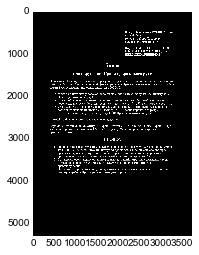

In [2]:
source, shred_config = utils.load_targets()
mask = shred_config.mask
imshow(source, cmap='gray')
print "Document used for training/testing."

In [3]:
graph = utils.cut_to_shreds(source.shape, shred_config)
print 'Total shreds:',len(graph)

for node in graph.nodes():
    if not utils.is_good_node(source[graph.node[node]['slice']]):
        graph.remove_node(node)
print "'Good', non-empty shreds:", len(graph)

Total shreds: 282
'Good', non-empty shreds: 123


Non-empty shreds layout.


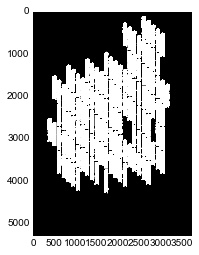

In [4]:
pattern = np.zeros(source.shape)
for n in graph:
    pattern[dataset.to_slice(n, shred_config.mask.shape)] = shred_config.mask
imshow(pattern, cmap='gray')
print "Non-empty shreds layout."

(587, 119)


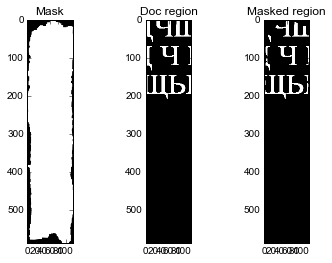

In [5]:
# Pick random shred for further processing.
import random
key1 = random.choice(graph.nodes())
# Apply shred mask to a random rectangular doc slice.
subplot(131)
title("Mask")
imshow(mask, cmap='gray')
subplot(132)
title("Doc region")
imshow(source[graph.node[key1]['slice']], cmap='gray')
subplot(133)
title("Masked region")
imshow(utils.masked_shred(source[graph.node[key1]['slice']], mask), cmap='gray')
print mask.shape

(687, 219)


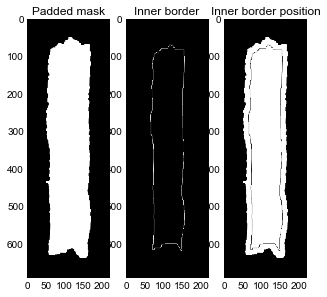

In [6]:
# Pad shred mask and determine border points.
# A window slides over border points to find partial characters.

padded_mask = dataset.pad_image(mask, dataset.WINDOW_SIDE)

border_obj = border_m.ShredMaskBorder(padded_mask)
border = border_obj.get_border_mask()
figure(num=None, figsize=(5, 10), facecolor='w', edgecolor='k')
subplot(131)
title("Padded mask")
imshow(padded_mask, cmap='gray')
subplot(132)
title("Inner border")
imshow(border, cmap='gray')
subplot(133)
title("Inner border position")
imshow(cv2.bitwise_xor(padded_mask, border), cmap='gray')

border_points = border_obj.get_border_points()  # Coordinates within padded mask/shred image.
print padded_mask.shape

In [7]:
all_samples, all_labels = classifier.get_dataset()
print len(all_samples)

145287


In [14]:
import os, sys
sys.path.append(os.path.dirname(classifier.__file__))

In [15]:
cl = classifier.get_classifier()
cl2 = classifier.get_classifier(classifier_type='lsh')

(736, 2500)


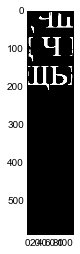

In [16]:
shred = utils.masked_shred(source[graph.node[key1]['slice']], mask)

padded_shred = dataset.pad_image(shred, dataset.WINDOW_SIDE)
imshow(shred, cmap='gray')

# Windows from this shred's borders.
samples = []
sample_coords = []
c = 0
for b in border_points:   
    window_origin = b - dataset.WINDOW_SHAPE / 2
    window_slice_index = dataset.to_slice(window_origin, dataset.WINDOW_SHAPE)
    window = padded_shred[window_slice_index]

    mask_window = padded_mask[window_slice_index]
    outermost = utils.preserve_outermost(window, mask_window)
    
    if not utils.is_good_node(outermost):
        continue
    
    sample = (outermost / 255.).flatten()
    samples.append(sample)
    sample_coords.append(window_origin)
    
    c += 1

    #output = padded_shred.copy()
    #cv2.imshow("Window", window)
    #cv2.rectangle(output, tuple((b-window_shape/2)[::-1]), tuple((b + window_shape/2)[::-1]), (255,0,0,255))
    #cv2.imshow("Shred", output)
    #cv2.waitKey(10)
samples = np.array(samples)
print samples.shape

In [17]:
res = cl.predict(samples)

In [18]:
#res2 = cl2.predict(samples)

Total labels: 37


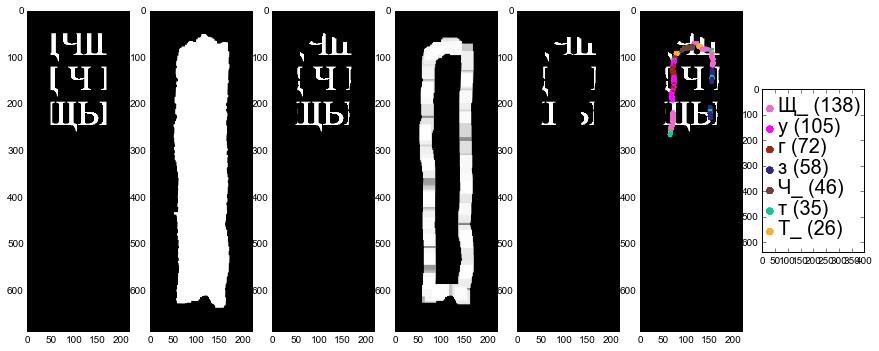

In [19]:
import collections

found_labels = set(res)
num_labels = len(found_labels)
colors = np.random.randint(0, 256, size=(num_labels, 4))
colors[:, 3] = 255

label2color = dict(zip(found_labels, colors))
print "Total labels:", num_labels

top_labels_to_pick = 7
top_labels = [x[0] for x in collections.Counter(res).most_common(top_labels_to_pick)]

row_height = 80
legend = np.ones(((top_labels_to_pick+1) * row_height, 400, 3), dtype=shred.dtype) * 255

output = cv2.cvtColor(padded_shred.copy(), cv2.cv.CV_GRAY2BGRA)
for coords, label in zip(sample_coords, res):
    if label not in top_labels: continue
    coords = coords +  dataset.WINDOW_SHAPE / 2
    cv2.circle(output, (coords[1], coords[0]), 5, label2color[label], thickness=-1)

    
covered_area = cv2.dilate(border, np.ones(dataset.WINDOW_SHAPE/2))
        
figure(num=None, figsize=(15, 10))
subplot(171)
imshow(dataset.pad_image(source[graph.node[key1]['slice']], dataset.WINDOW_SIDE), cmap='gray')
subplot(172)
imshow(padded_mask, cmap='gray')
subplot(173)
imshow(padded_shred, cmap='gray')
subplot(174)
imshow(covered_area, cmap='gray')
subplot(175)
imshow(cv2.bitwise_and(padded_shred, padded_shred, mask=covered_area), cmap='gray')
subplot(176)
imshow(output)
subplot(177)
    
for i, label in enumerate(top_labels):
    cv2.circle(legend, (30, (i+1) * row_height), 15, label2color[label][:3], thickness=-1)
    text(60, (i+1.1) * row_height, unicode("%s (%d)" % (label, collections.Counter(res)[label]), 'utf-8'), color='black', fontsize=20)

imshow(legend)


29 736
Sample window classification
И_ 2
Й_ 92
Ю_ 3
Custom super classifier prediction: Ш_


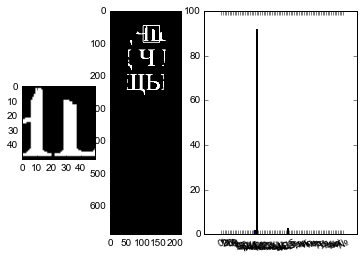

In [20]:
i = np.random.randint(0, len(res))

print i, len(res)

image = (samples[i] * 255).reshape(dataset.WINDOW_SHAPE).astype("uint8")

output = padded_shred.copy()
point_a = sample_coords[i] [::-1]
point_b = tuple(point_a + dataset.WINDOW_SHAPE)
cv2.rectangle(output, tuple(point_a), point_b, (250), 2)

subplot(141)
imshow(utils.preserve_outermost(image, mask_window), cmap='gray')
subplot(142)
imshow(output, cmap='gray')

proba = cl.predict_proba(samples[i:i+1])[0]
proba = (proba*100).astype('int8')

cl2_prediction = cl2.predict(samples[i:i+1])

subplot(122)
plt.bar(range(len(proba)), proba, align='center')
_ = plt.xticks(range(len(proba)), map(lambda x: unicode(x, 'utf-8'), cl._dbn.classes_), rotation=25)

print "Sample window classification"
for c, prob in zip(cl._dbn.classes_[proba>0], proba[proba>0]):
    print c, prob

print "Custom super classifier prediction:", cl2_prediction[0]

In [21]:
flat_image = image.flatten().astype(np.float32)
all_distances = [np.linalg.norm(flat_image - sample) for sample in all_samples]

Bitwise closest image
Closest label: Ш_ distance: 3685.36 idx: 116037


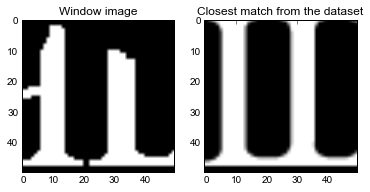

In [22]:
closest_idx = np.argmin(all_distances)
closest = all_samples[closest_idx].reshape(dataset.WINDOW_SHAPE)
closest_label = all_labels[closest_idx]

subplot(121)
title("Window image")
imshow(image, 'gray')
subplot(122)
title("Closest match from the dataset")
imshow(closest, 'gray')

print "Bitwise closest image"
print "Closest label:", closest_label, "distance:", all_distances[closest_idx], "idx:", closest_idx

In [23]:
with classifier.Profile("DBN prediction"):
    print cl.predict(np.array([samples[i]]))[0]
with classifier.Profile("DBNNN prediction"):
    print cl2.predict(np.array([samples[i]]))[0]

Й_
Ш_


In [24]:
(trainX, testX, trainY, testY) = classifier.train_test_split(
            all_samples / 255.0, all_labels, test_size = 0.1)

In [25]:
print len(testX)

14529


In [26]:
with classifier.Profile("cl report"):
    preds = cl.predict(testX)
    print classifier.classification_report(testY, preds)

             precision    recall  f1-score   support

          0       0.85      0.89      0.87       171
          1       0.77      0.83      0.80        93
          2       0.95      0.94      0.94       192
          3       0.87      0.90      0.88       162
          4       0.80      0.75      0.77       186
          5       0.83      0.78      0.81       167
          6       0.84      0.79      0.82       188
          7       0.96      0.99      0.97       156
          8       0.83      0.89      0.86       141
          9       0.75      0.79      0.77       154
        І_       0.41      0.66      0.51       109
      Ї_       0.63      0.62      0.62       125
        А_       0.90      0.87      0.88       272
        Б_       0.75      0.73      0.74       256
        В_       0.70      0.80      0.74       251
        Г_       0.61      0.64      0.63       197
        Д_       0.70      0.58      0.64       331
        Е_       0.80      0.78      0.79       222
 

In [27]:
with classifier.Profile("cl2 report"):
    preds = cl2.predict(testX)
    print classifier.classification_report(testY, preds)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       171
          1       1.00      1.00      1.00        93
          2       1.00      1.00      1.00       192
          3       1.00      1.00      1.00       162
          4       1.00      1.00      1.00       186
          5       1.00      1.00      1.00       167
          6       1.00      1.00      1.00       188
          7       1.00      1.00      1.00       156
          8       1.00      1.00      1.00       141
          9       1.00      1.00      1.00       154
        І_       0.69      0.73      0.71       109
      Ї_       0.75      0.71      0.73       125
        А_       1.00      1.00      1.00       272
        Б_       1.00      1.00      1.00       256
        В_       1.00      1.00      1.00       251
        Г_       1.00      1.00      1.00       197
        Д_       1.00      1.00      1.00       331
        Е_       1.00      1.00      1.00       222
 